In [25]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [26]:
df=pd.read_csv("/Users/joshuascantlebury/WeekendProjects/Betting App/data/similarplayer.csv")

In [27]:
X = df[['PTS', 'REB', 'AST']]

In [28]:
kmeans = KMeans(n_clusters=5, random_state=23).fit(X)

In [29]:
df['cluster'] = kmeans.labels_


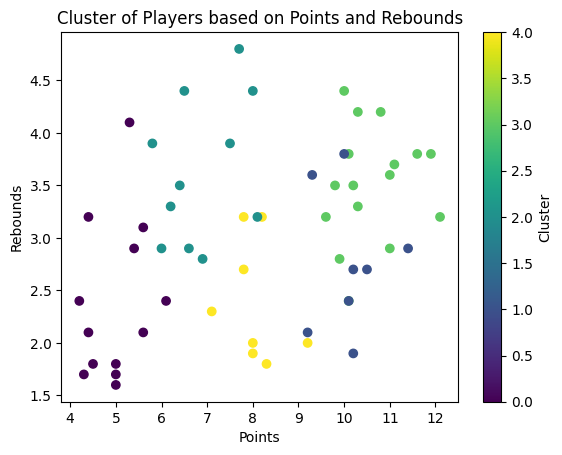

    PERSON_ID   PTS  REB  AST  cluster
0     1629638   8.0  2.0  2.5        4
1     1630631   7.1  2.3  2.1        4
2      203937   6.4  3.5  4.2        2
3     1630175  11.6  3.8  2.9        3
4     1630625  10.3  3.3  2.4        3
5      201587   5.3  4.1  2.1        0
6      201976   6.2  3.3  2.9        2
7     1631103   9.2  2.0  2.1        4
8     1628971  10.8  4.2  2.9        3
9      203484  10.1  2.4  2.4        3
10    1627936  10.1  3.8  3.5        3
11     201144  11.4  2.9  5.9        1
12    1626192   5.6  3.1  2.1        0
13    1630700   5.8  3.9  2.7        2
14     203915  10.5  2.7  4.7        1
15    1630288   4.3  1.7  2.3        0
16    1627739   5.4  2.9  3.8        0
17     203957   7.8  2.7  2.9        4
18    1628365   7.8  3.2  2.8        4
19    1630692   6.5  4.4  2.7        2
20    1628984   5.0  1.6  2.1        0
21    1630182   8.2  3.2  2.3        4
22    1630204   4.2  2.4  2.8        0
23    1630165   6.9  2.8  4.9        2
24     202330   9.8  3.5 

In [30]:
plt.scatter(df['PTS'], df['REB'], c=df['cluster'], cmap='viridis')
plt.xlabel('Points')
plt.ylabel('Rebounds')
plt.title('Cluster of Players based on Points and Rebounds')
plt.colorbar(label='Cluster')
plt.show()

# Optionally print the DataFrame with cluster labels
print(df[['PERSON_ID', 'PTS', 'REB', 'AST', 'cluster']])

In [35]:
### Get All teams
from nba_api.stats.static import teams

nba_teams = teams.get_teams()

### Get games of current season
from nba_api.stats.endpoints import leaguegamefinder
games_per_team = []
for team in nba_teams:
    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team['id'])
    games = gamefinder.get_data_frames()[0]
    games.GAME_DATE = pd.to_datetime(games.GAME_DATE)
    ### Here i choose games from the current 2023-2024 Season (without pre-season games)
    games_per_team.append(games[(games.SEASON_ID == '22023') & (games.GAME_DATE >= '2023-10-24')])

### Get the Offensive rating, the Defensive rating and other relative stats
from nba_api.stats.endpoints import boxscoreadvancedv3

target_stats = []
for team in games_per_team:
    ### Take number of Win and Losses
    WL = team.WL.value_counts().reset_index()
    W = WL[WL.WL == 'W']['count'].values[0]
    L = WL[WL.WL == 'L']['count'].values[0]
    ### Get classic stats
    target_stats.append({'team_abbreviation':team.TEAM_ABBREVIATION.unique()[0],
                         'team_name':team.TEAM_NAME.unique()[0],
                         'game_date':team.GAME_DATE.to_list(),
                         'W':W,
                         'L':L,
                         'offensive_rating':[], 
                         'defensive_rating':[],
                         'possessions':[] 
                         })
    
    ### Get advanced stats
    for id in team.GAME_ID.to_list():
        stats = boxscoreadvancedv3.BoxScoreAdvancedV3(game_id=id) 
        ### If the team is an away team during the game, you take the stats in the awayTeam key
        if team[team.GAME_ID == id].MATCHUP.values[0][4] == "@":  ### Away Team
            target_stats[-1]['offensive_rating'].append(stats.get_dict()['boxScoreAdvanced']['awayTeam']['statistics']['offensiveRating'])
            target_stats[-1]['defensive_rating'].append(stats.get_dict()['boxScoreAdvanced']['awayTeam']['statistics']['defensiveRating'])
            target_stats[-1]['possessions'].append(stats.get_dict()['boxScoreAdvanced']['awayTeam']['statistics']['possessions'])
        else:
            target_stats[-1]['offensive_rating'].append(stats.get_dict()['boxScoreAdvanced']['homeTeam']['statistics']['offensiveRating'])
            target_stats[-1]['defensive_rating'].append(stats.get_dict()['boxScoreAdvanced']['homeTeam']['statistics']['defensiveRating'])
            target_stats[-1]['possessions'].append(stats.get_dict()['boxScoreAdvanced']['homeTeam']['statistics']['possessions'])

### Compute metrics
data = pd.DataFrame(target_stats)
data['GP'] = data.W + data.L
data['PCT_W'] = (data.W / data.GP)*100
data['PCT_W_rank'] = data.PCT_W.rank(method='min', ascending=False).astype('int64')
data.head()

KeyError: 'count'